In [21]:
import config
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import warnings

In [22]:
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf

In [23]:
connect = psycopg2.connect(
    dbname=config.dbname,
    user=config.user,
    password=config.password,
    host=config.host,
    port=config.port
)
cur = connect.cursor()
query = '''
        SELECT timestamp, high_price
        FROM nvidia;
''' 
cur.execute(query)
results = cur.fetchall()
cur.close()
connect.close()

In [24]:
scaler = StandardScaler()
main_df = pd.DataFrame(results, columns=['timestamp', 'high_price'])
main_df['timestamp'] = pd.to_datetime(main_df['timestamp'])
main_df.set_index('timestamp', inplace=True)
main_df = main_df[::-1]
main_df[['high_price']] = scaler.fit_transform(main_df[['high_price']])
main_df.head()

,high_price
timestamp,
1999-12-31,-0.428595
2000-01-31,-0.423991
2000-02-29,-0.310318
2000-03-31,0.154320
2000-04-28,-0.070752


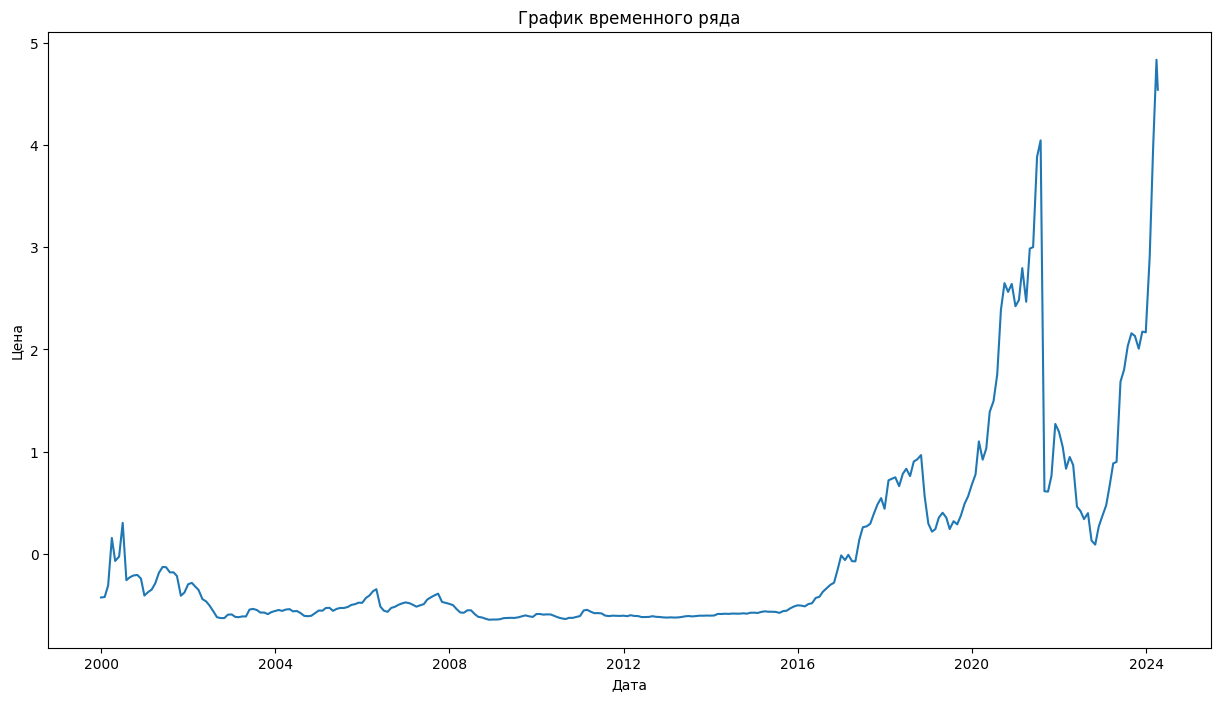

In [25]:
plt.figure(figsize=(15,8))
plt.plot(main_df['high_price'])
plt.title('График временного ряда')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.show()

In [26]:
print('Результат теста:')
df_result = adfuller(main_df['high_price'])
df_labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
for result_value, label in zip(df_result, df_labels):
    print(label + ' : ' + str(result_value))

if df_result[1] <= 0.05:
    print("Сильные доказательства против нулевой гипотезы, ряд является стационарным.")
else:
    print("Слабые доказательства против нулевой гипотезы, ряд не является стационарным.")

Результат теста:
ADF Test Statistic : -0.3719389785942733
p-value : 0.9146795917337094
#Lags Used : 9
Number of Observations Used : 283
Слабые доказательства против нулевой гипотезы, ряд не является стационарным.


In [27]:
warnings.filterwarnings("ignore")

def search_optimal_sarima(main_df, seasonal_cycle):
    order_vals = diff_vals = ma_vals = range(0, 2)
    pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))
    seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]
       
    smallest_aic = float("inf")
    optimal_order_param = optimal_seasonal_param = None

    for order_param in pdq_combinations:
        for seasonal_param in seasonal_combinations:
            try:
                sarima_model = SARIMAX(
                    main_df,
                    order=order_param,
                    seasonal_order=seasonal_param,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

                model_results = sarima_model.fit()
                if model_results.aic < smallest_aic:
                    smallest_aic = model_results.aic
                    optimal_order_param = order_param
                    optimal_seasonal_param = seasonal_param
            except:
                continue

    print('ARIMA{}x{} - AIC:{}'.format(optimal_order_param, optimal_seasonal_param, smallest_aic))

seasonal_cycle_length = 12
search_optimal_sarima(main_df, seasonal_cycle_length)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41549D+00    |proj g|=  2.77602D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   6.934D-06   1.415D+00
  F =   1.4154868100688565     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.2

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     43      2     0     0   1.031D-05   1.061D+00
  F =   1.0614967103331010     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16387D+00    |proj g|=  1.44613D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.14226D-01    |proj g|=  3.92978D-01

At iterate   10    f=  6.06790D-01    |proj g|=  4.39554D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     17      1     0     0   2.939D-06   6.068D-01
  F =  0.60679018561409925     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08939D+00    |proj g|=  7.99184D-01

At iterate    5    f=  6.91833D-01    |proj g|=  3.04945D-02

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   6.422D-06   6.242D-01
  F =  0.62417217137406389     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.05700D-01    |proj g|=  7.27064D-01

At iterate    5    f=  6.47224D-01    |proj g|=  1.54562D-02

At iterate   10    f=  6.47074D-01    |proj g|=  1.81402D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  6.46993D-01    |proj g|=  2.07765D-01

At iterate   10    f=  5.98913D-01    |proj g|=  1.10775D-02

At iterate   15    f=  5.98883D-01    |proj g|=  3.04503D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     22      1     0     0   3.045D-05   5.989D-01
  F =  0.59888295720325779     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.73304D-02    |proj g|=  2.62966D-02

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      8      1     0     0   4.147D-05   4.162D-01
  F =  0.41618202204776084     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51961D-01    |proj g|=  8.65348D-01

At iterate    5    f=  1.25674D-01    |proj g|=  9.74138D-03

At iterate   10    f=  1.25522D-01    |proj g|=  1.80787D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13355D-02    |proj g|=  2.85587D-01

At iterate    5    f=  5.95539D-02    |proj g|=  6.81985D-02

At iterate   10    f=  5.86685D-02    |proj g|=  1.12537D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   5.549D-06   5.867D-02
  F =   5.8665004726439096E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     29      1     0     0   2.015D-05   1.161D-01
  F =  0.11606674757609647     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.52148D-02    |proj g|=  2.50795D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   5.597D-06   2.635D-01
  F =  0.26349076919256847     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00049D-01    |proj g|=  1.13076D+00

At iterate    5    f=  1.13663D-01    |proj g|=  2.27782D-02


 This problem is unconstrained.



At iterate   10    f=  1.13027D-01    |proj g|=  4.49165D-04

At iterate   15    f=  1.13027D-01    |proj g|=  1.55075D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   1.551D-05   1.130D-01
  F =  0.11302660388193232     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58201D-02    |proj g|=  1.49140D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04851D-01    |proj g|=  7.46287D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     20      1     0     0   7.463D-05   4.049D-01
  F =  0.40485056165019129     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f=  3.67170D-01    |proj g|=  2.35225D+00

At iterate    5    f=  6.33738D-02    |proj g|=  2.87328D-01

At iterate   10    f=  5.99105D-02    |proj g|=  7.59723D-02

At iterate   15    f=  5.70003D-02    |proj g|=  3.78893D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     24      1     0     0   8.359D-06   5.700D-02
  F =   5.6999278069049690E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.76187D-01    |proj g|=  2.11583D-01

At iterate   10    f=  1.17180D-01    |proj g|=  1.46022D-01

At iterate   15    f=  1.15620D-01    |proj g|=  9.01234D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   1.385D-04   1.156D-01
  F =  0.11561947960440033     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.37782D-02    |proj g|=  1.64910D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.23865D-01    |proj g|=  3.85660D-02

At iterate   10    f=  1.22722D-01    |proj g|=  6.23939D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     20      1     0     0   4.196D-05   1.227D-01
  F =  0.12272199563169227     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69075D-01    |proj g|=  2.40606D+00

At iterate    5    f=  7.85926D-02    |proj g|=  7.14391D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.10915D-02    |proj g|=  2.92911D-01

At iterate   10    f=  5.72631D-02    |proj g|=  5.21591D-02

At iterate   15    f=  5.39566D-02    |proj g|=  5.17596D-03

At iterate   20    f=  5.39364D-02    |proj g|=  9.97119D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     26      1     0     0   9.971D-06   5.394D-02
  F =   5.3936361874803232E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56475D-01    |proj g|=  3.43088D-01

At iterate    5    f=  2.66202D-01    |proj g|=  2.69183D-01

At iterate   10    f=  1.14576D-01    |proj g|=  1.91023D-01

At iterate   15    f=  1.12143D-01    |proj g|=  5.37314D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   1.186D-05   1.121D-01
  F =  0.11214226716170660     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.23677D-01    |proj g|=  6.16140D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     13      1     0     0   1.563D-04   1.237D-01
  F =  0.12367666436919496     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.59446D-02    |proj g|=  4.69331D-02

At iterate    5    f=  5.57840D-02    |proj g|=  1.66771D-03

At iterate   10    f=  5.57839D-02    |proj g|=  3.66919D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82491D-01    |proj g|=  6.14233D-01

At iterate    5    f=  2.64848D-01    |proj g|=  1.40410D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   1.383D-05   2.648D-01
  F =  0.26483595292217982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   10    f=  1.13441D-01    |proj g|=  5.21000D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   3.426D-05   1.134D-01
  F =  0.11344131737428613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.45097D-02    |proj g|=  2.43179D-02

At iterate    5    f=  6.28632D-02    |proj g|=  8.03591D-02

At iterate   10    f=  5.80606D-02    |proj g|=  6.20301D-03

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     24      1     0     0   7.110D-06   5.107D-02
  F =   5.1066124098495543E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.15919D-01    |proj g|=  1.00851D-02

At iterate    5    f=  4.15844D-01    |proj g|=  1.14184D-02

At iterate   10    f=  3.91521D-01    |proj g|=  2.99314D-01

At iterate   15    f=  3.85482D-01    |proj g|=  2.47168D-04

       

 This problem is unconstrained.



At iterate    5    f=  1.24815D-01    |proj g|=  2.51238D-02

At iterate   10    f=  1.24669D-01    |proj g|=  2.32474D-02

At iterate   15    f=  1.15796D-01    |proj g|=  2.61270D-02

At iterate   20    f=  1.15480D-01    |proj g|=  4.13100D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     40      1     0     0   1.056D-05   1.155D-01
  F =  0.11547975597368146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.40057D-02    |proj g|=  2.84263D-02

At iterate   10    f=  5.18913D-02    |proj g|=  1.09368D-01

At iterate   15    f=  5.08873D-02    |proj g|=  2.07875D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     26      1     0     0   8.230D-06   5.089D-02
  F =   5.0887227631859544E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.63426D-02    |proj g|=  3.62481D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83220D-01    |proj g|=  6.17210D-01

At iterate    5    f=  2.65360D-01    |proj g|=  6.62070D-03

At iterate   10    f=  2.57952D-01    |proj g|=  1.87805D-01

At iterate   15    f=  2.42691D-01    |proj g|=  6.80790D-02

At iterate   20    f=  2.42487D-01    |proj g|=  1.64226D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   3.031D-06   2.425D-01
  F =  0.24248718789182597     

CONVERG

 This problem is unconstrained.



At iterate   10    f=  1.14094D-01    |proj g|=  2.90740D-02

At iterate   15    f=  1.09680D-01    |proj g|=  2.22349D-01

At iterate   20    f=  1.07269D-01    |proj g|=  1.26558D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     37      1     0     0   1.180D-05   1.073D-01
  F =  0.10726760212220814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:37.24833805479132


In [29]:
model = SARIMAX(main_df, order=(0, 1, 1), seasonal_order=(1, 0, 0, 12))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.59316D-02    |proj g|=  5.29691D-02

At iterate    5    f=  5.57501D-02    |proj g|=  2.87119D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   6.300D-05   5.575D-02
  F =   5.5749931950568196E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          high_price   No. Observations:                  293
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                 -16.335
Date:                             Wed, 24 Apr 2024   AIC                             38.669
Time:                                     21:22:40   BIC                             49.700
Sample:                                          0   HQIC                            43.088
                                             - 293                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0922      0.040      2.326      0.020       0.014       0.170
ar.S.L12      -0.1255      0.046     -2.718      0.007      -0.216      -0.035
sigma2         0.0654      0.001     50.632      0.000       0.063       0.068
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):            137287.99
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):              19.48   Skew:                            -7.32
Prob(H) (two-sided):                  0.00   Kurtosis:                       108.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

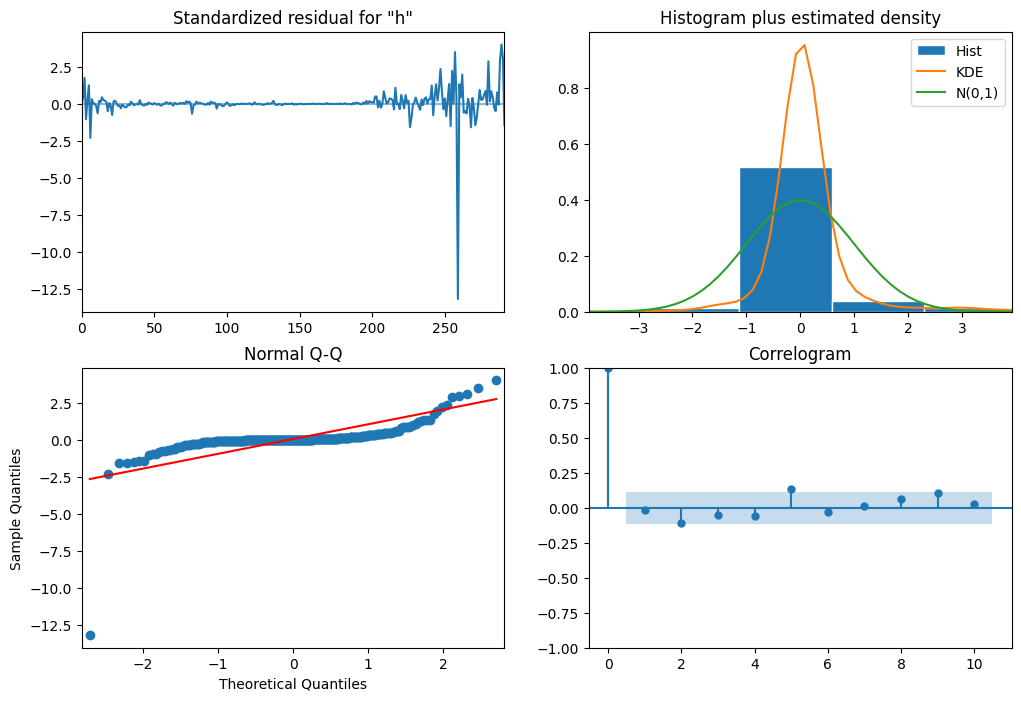

In [30]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()

Среднеквадратичная ошибка прогноза составляет 0.06


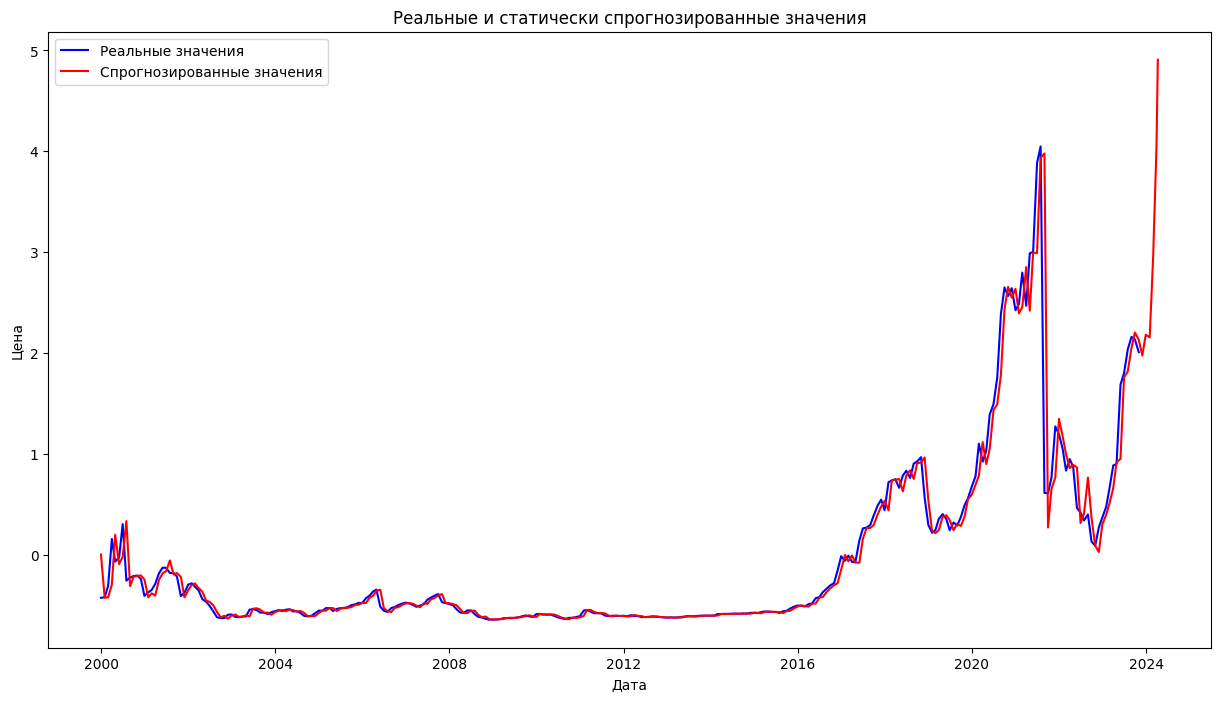

In [90]:
st_pred = results.get_prediction(start=pd.to_datetime('1999-12-31'), dynamic=False) 
forecast_values = st_pred.predicted_mean

actual_values = main_df['1999-12-31': '2023-10-31']['high_price']
forecast_mse = ((forecast_values - actual_values) ** 2).mean()
print('Среднеквадратичная ошибка прогноза составляет {}'.format(round(forecast_mse, 2)))

plt.figure(figsize=(15,8))

plt.plot(actual_values.index, actual_values, label='Реальные значения', color='blue')

plt.plot(forecast_values.index, forecast_values, label='Спрогнозированные значения', color='red')

plt.title('Реальные и статически cпрогнозированные значения')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

Среднеквадратичная ошибка динамического прогноза составляет 0.02


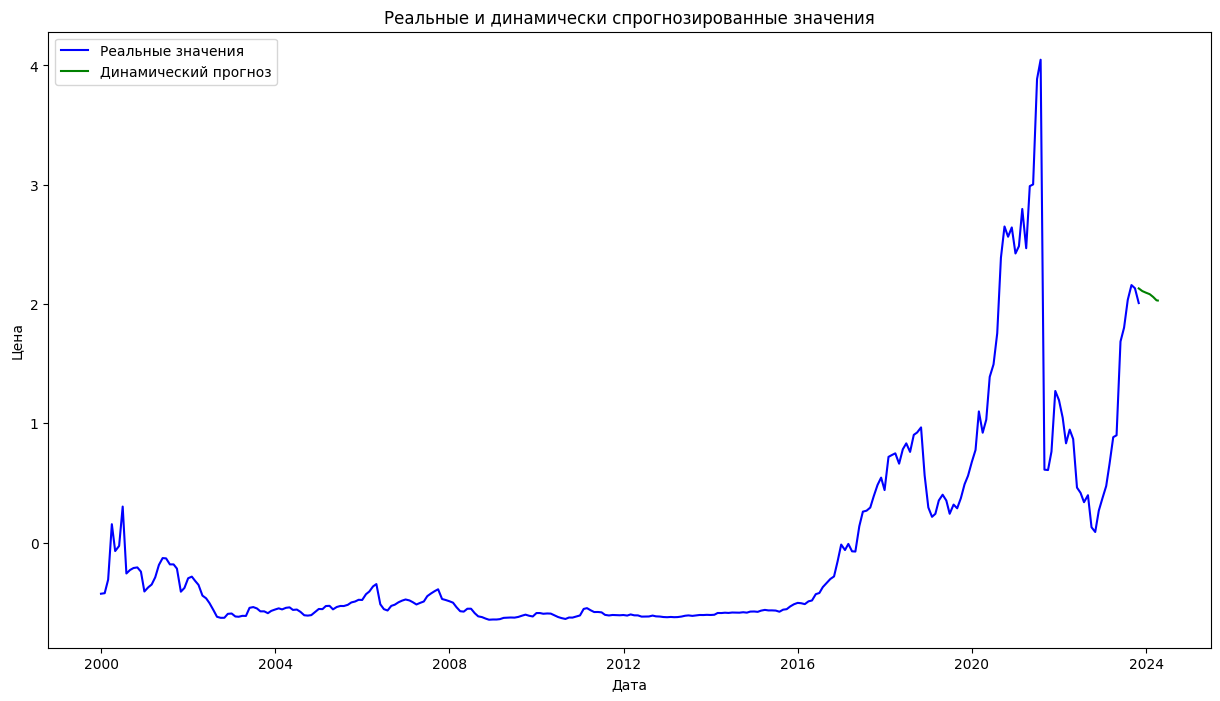

In [59]:
dyn_pred = results.get_prediction(start=pd.to_datetime('2023-10-31'), dynamic=True) 
dynamic_forecast_values = dyn_pred.predicted_mean

mse_dynamic_forecast = ((dynamic_forecast_values - actual_values) ** 2).mean()
print('Среднеквадратичная ошибка динамического прогноза составляет {}'.format(round(mse_dynamic_forecast, 2)))

plt.figure(figsize=(15,8))

plt.plot(actual_values.index, actual_values, label='Реальные значения', color='blue')

plt.plot(dynamic_forecast_values.index, dynamic_forecast_values, label='Динамический прогноз', color='green')

plt.title('Реальные и динамически спрогнозированные значения')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

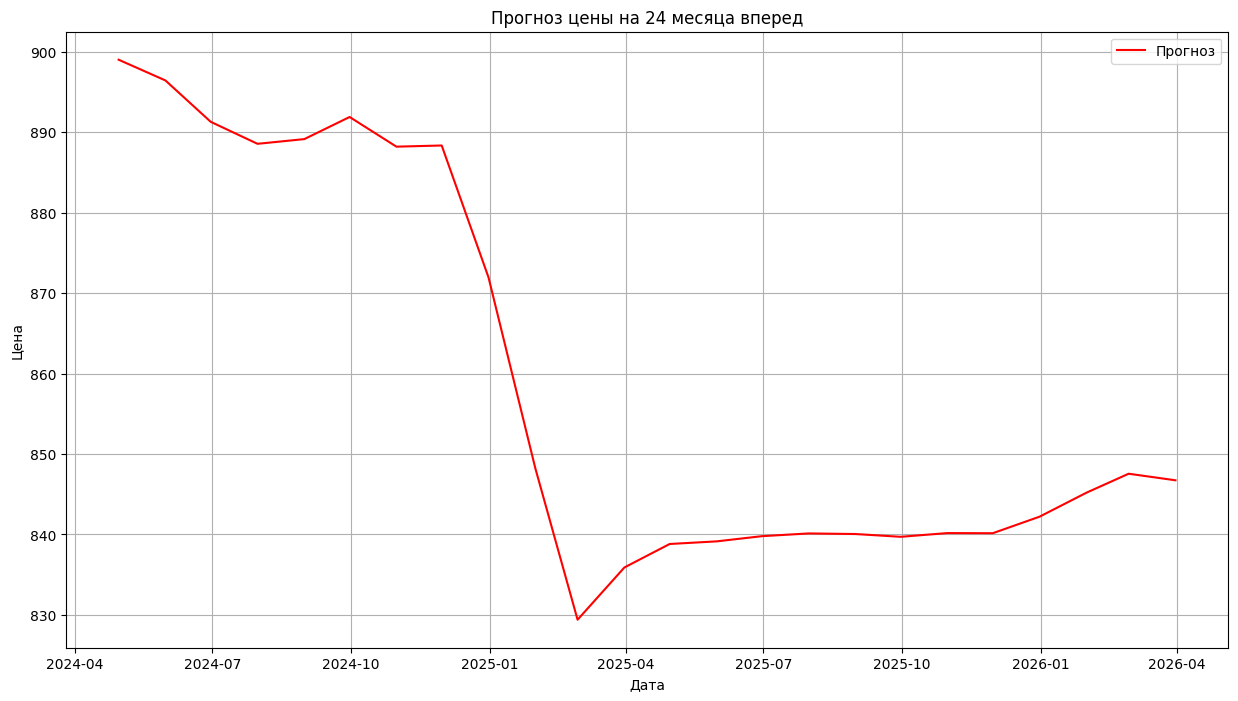

In [86]:
forecast = results.get_forecast(steps=24, method='mle') 
forecast_values = forecast.predicted_mean
forecast_values.head()
forecast_values_array = np.array(forecast_values)
forecast_values_reshaped = forecast_values_array.reshape(-1, 1)
forecast_values_unscaled = scaler.inverse_transform(forecast_values_reshaped).flatten()
forecast_dates = pd.date_range(start='2024-04-02', periods=24, freq='ME')

plt.figure(figsize=(15, 8))
plt.plot(forecast_dates, forecast_values_unscaled, label='Прогноз', color='red')
plt.title('Прогноз цены на 24 месяца вперед')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()